In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
mnist = pd.read_csv('data/mnist_train.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.groupby('label')['1x1'].count()

label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: 1x1, dtype: int64

In [7]:
np.random.seed(1)
n_sam = 50
mnist50 = pd.DataFrame(columns=mnist.columns, dtype='int64')
for i in range(10):
    samples = mnist[mnist.label==i].sample(n_sam, replace=False)
    mnist50 = pd.concat([mnist50, samples], ignore_index=True)
mnist50.label.value_counts()

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
Name: label, dtype: int64

In [8]:
mnist50.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
mnist50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 3.0 MB


In [10]:
X = mnist50.drop(['label'], axis=1)
y = mnist50.label

In [11]:
def plot_mnist(img, label=''):
    plt.imshow(img.reshape((28,28)), cmap='gray')
    plt.title(str(label))
    plt.xticks([])
    plt.yticks([])

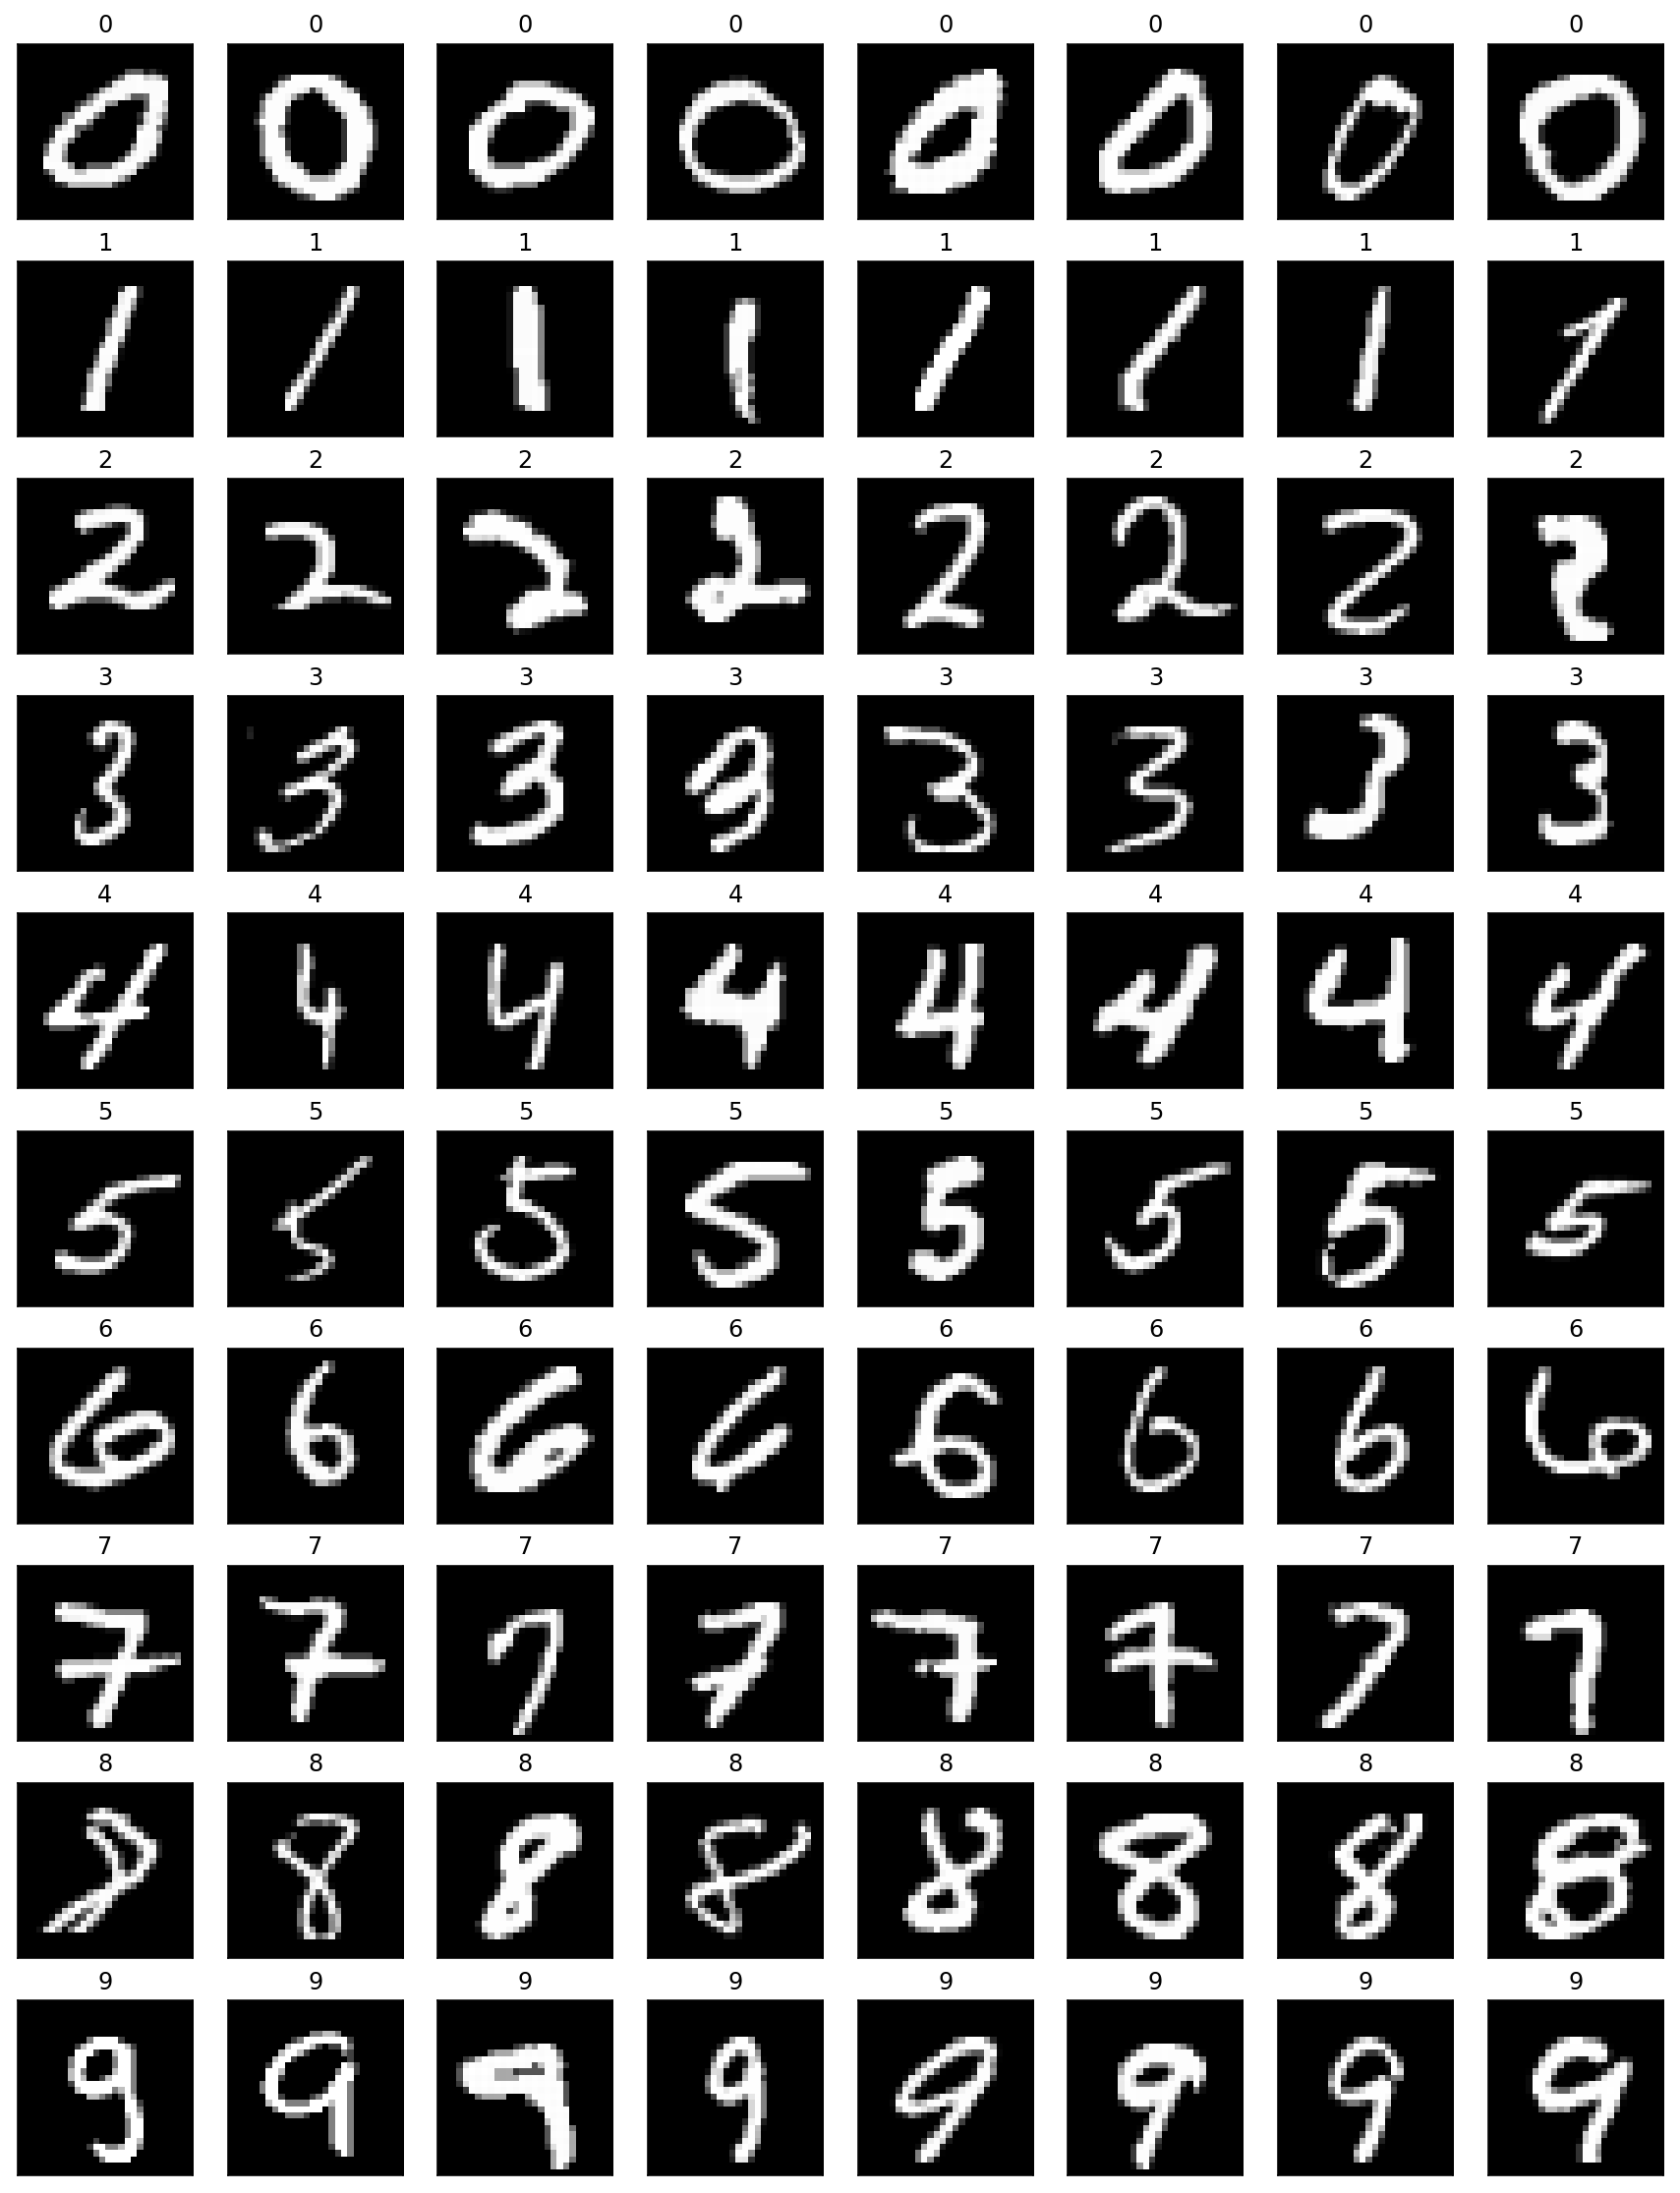

In [12]:
np.random.seed(0)
n_sam = 8
samples = {i:y[y==i].sample(n_sam, replace=False).index for i in range(10)}
plt.figure(figsize=(15,20))
for i in range(10*n_sam):
    dig, sam = i//n_sam, i%n_sam
    plt.subplot(10,n_sam,i+1)
    img = X.iloc[samples[dig][sam]].values.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(str(y[samples[dig][sam]]))
    plt.xticks([])
    plt.yticks([])

In [13]:
features = mnist50.drop('label', axis=1)
label = mnist50.label

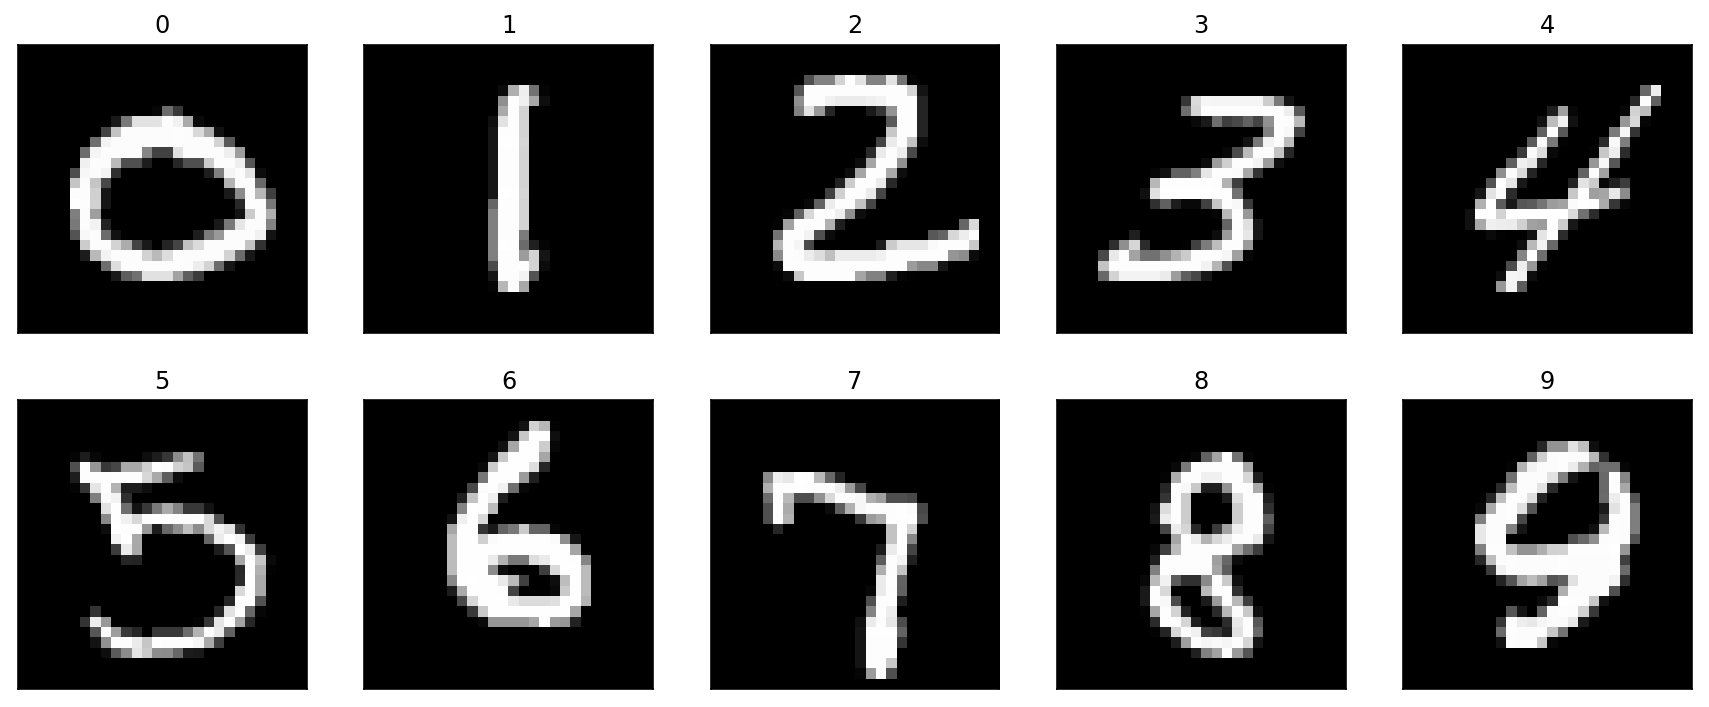

In [15]:
np.random.seed(32)
r, c = 2, 5
samp_ind = [label[label==i].sample(1, replace=False).index[0] for i in range(10)]
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img = features.iloc[samp_ind[i]].values.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(str(label[samp_ind[i]]))
    plt.xticks([])
    plt.yticks([])

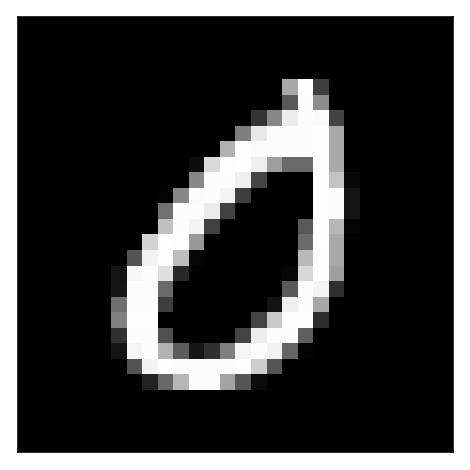

In [16]:
ind = 0
img = features.iloc[ind].values
plot_mnist(img)

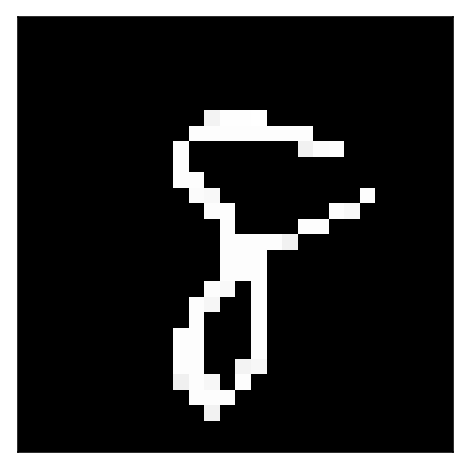

In [17]:
ind = 410
img = np.array(features.iloc[ind].values)
img[img<240]=0
plot_mnist(img)

In [95]:
def plot_coord(coord, marker='o', lim=(-1,101)):
    plt.scatter(coord[:,0], coord[:,1], marker=marker)
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xticks([])
    plt.yticks([])

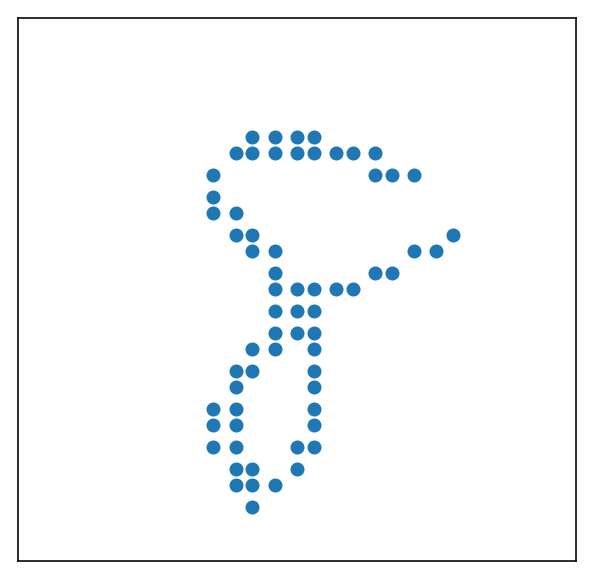

In [19]:
r, c = np.where(img.reshape((28,28))>240)
x_coor, y_coor = (c*100/28).astype('int64'), ((28-r)*100/28).astype('int64')
plt.figure(figsize=(5,5))
plot_coord(np.concatenate((x_coor.reshape(-1,1), y_coor.reshape(-1,1)), axis=1))

In [97]:
def img2coord(img, scale=100, pixval_min=1):
    r, c = np.where(img.reshape((28,28))>=pixval_min)
    x_coor, y_coor = (c*100/28).astype('int64'), ((28-r)*100/28).astype('int64')
    xycoors = np.concatenate((x_coor.reshape(-1,1), y_coor.reshape(-1,1)), axis=1)
    return xycoors

def mnist2clusters(img, pixval_min=100, scale=100):
    xycoors = img2coord(img, scale=scale, pixval_min=pixval_min)
    kmeans = KMeans(n_clusters=8)
    kmeans.fit(xycoors)
    return kmeans, xycoors

def plot_clusters(kmeans, xycoors, marker='o', lim=(-1,101), only_centroids=False):
    pred = kmeans.predict(xycoors)
    if only_centroids:
        plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*',color='k')
        plt.xlim(lim)
        plt.ylim(lim)
        plt.xticks([])
        plt.yticks([])
    else:   
        plt.scatter(xycoors[:,0], xycoors[:,1], c=pred, cmap='Dark2', marker=marker)
        plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*',color='k')
        plt.xlim(lim)
        plt.ylim(lim)
        plt.xticks([])
        plt.yticks([])      

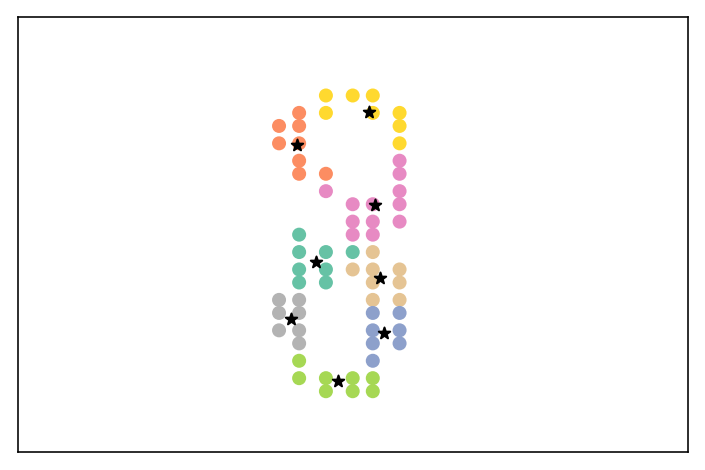

In [23]:
ind=449
km, xy = mnist2clusters(features.iloc[ind].values)
plot_clusters(km, xy)

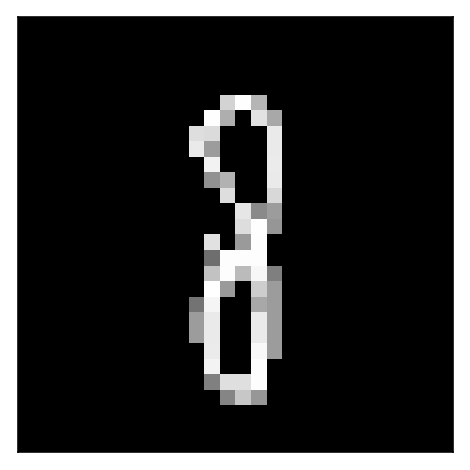

In [24]:
img = np.array(features.iloc[ind].values)
img[img<=100]=0
plot_mnist(img)

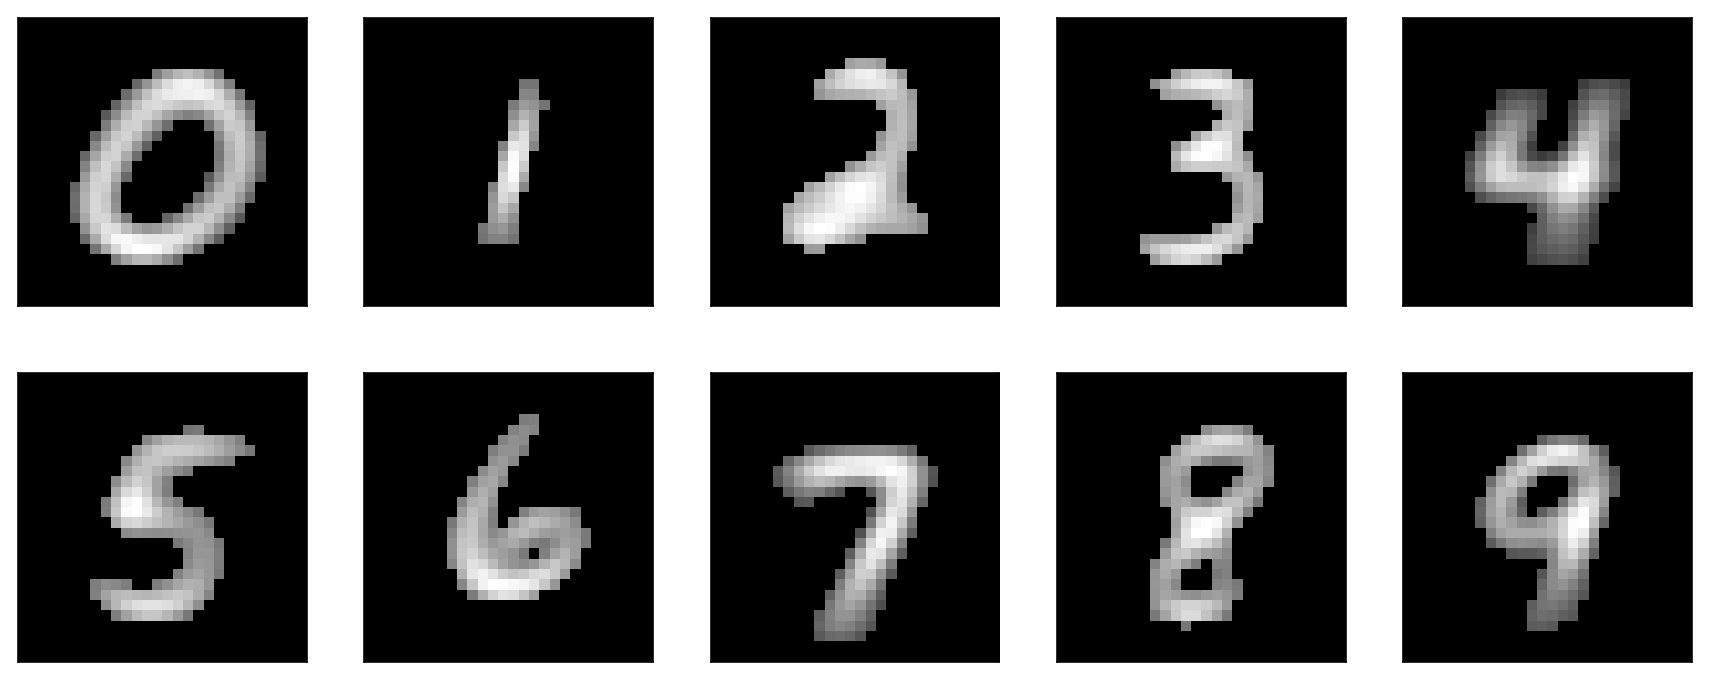

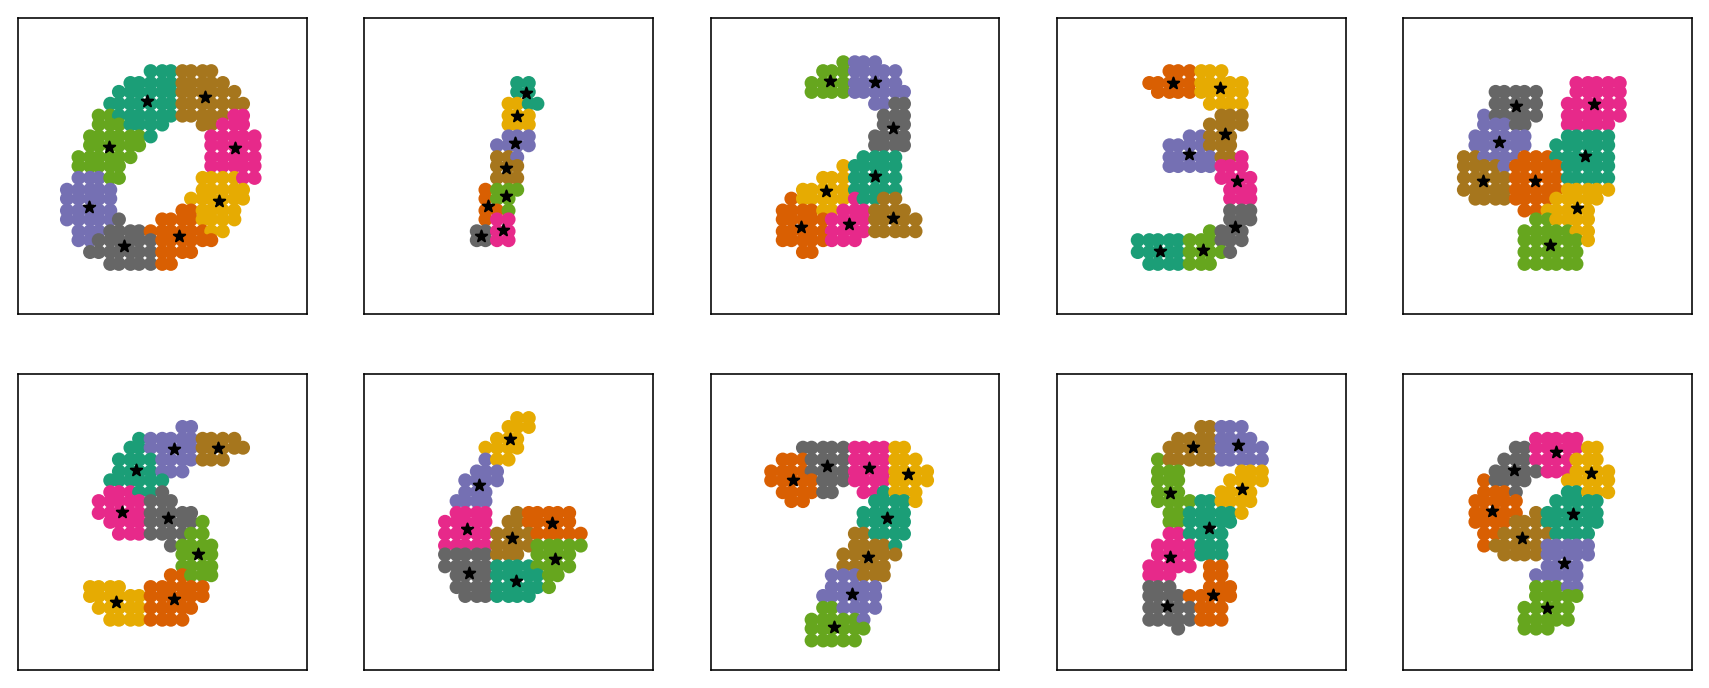

In [60]:
np.random.seed(2)
average_mnist = mnist.groupby('label').mean().astype('int64').values
thld = np.array([70,110,100,110,50,80,100,60,100,70])
#                0   1   2   3  4  5   6  7   8  9
centroids=[]
r, c = 2, 5
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img= average_mnist[i]
    img[img<thld[i]] = 0
    plot_mnist(img)
plt.show()
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img= average_mnist[i]
    img[img<thld[i]] = 0
    kmt,xy = mnist2clusters(img, pixval_min=thld[i])
    plot_clusters(kmt,xy)
    centroids.append(kmt.cluster_centers_)
plt.show()

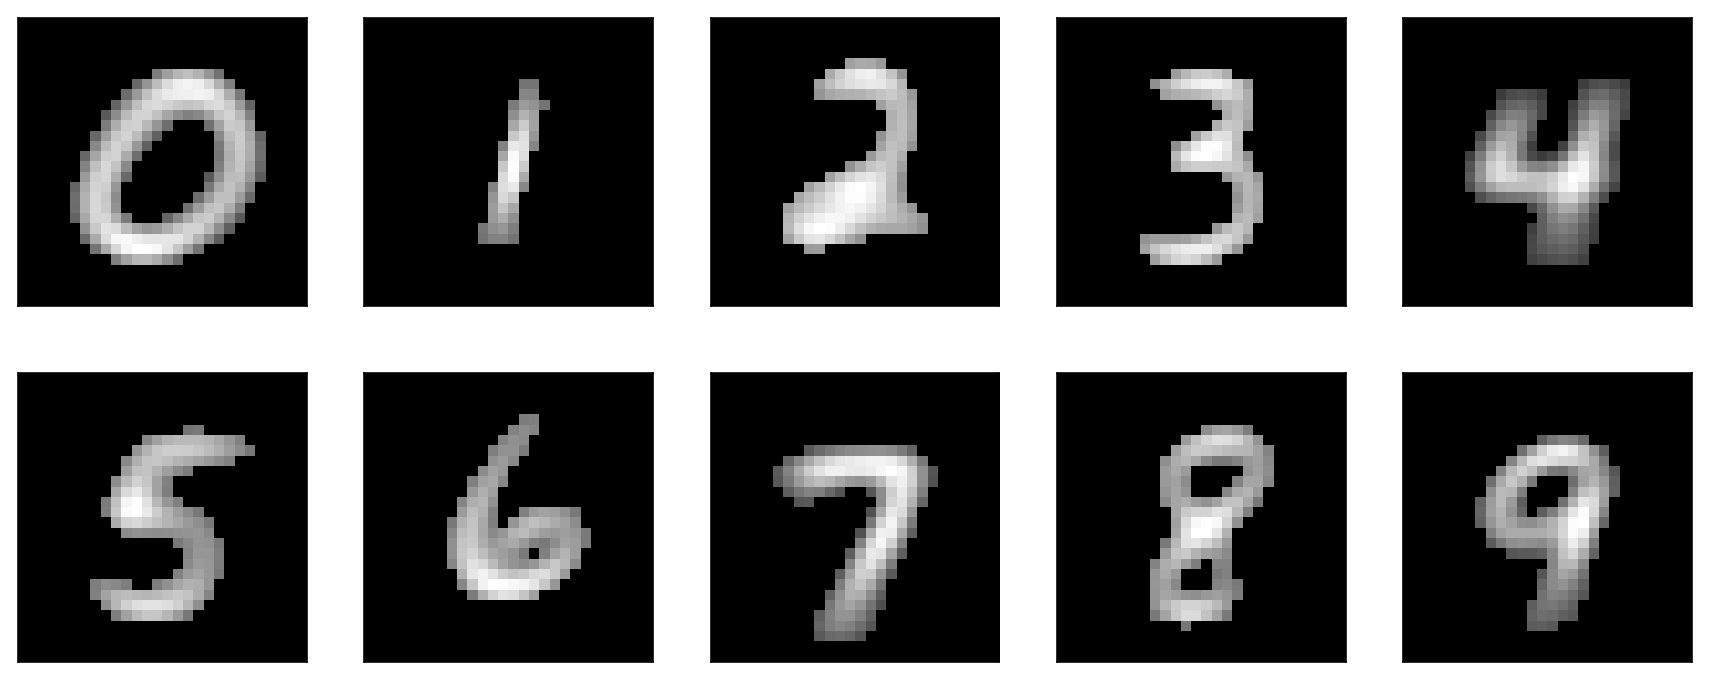

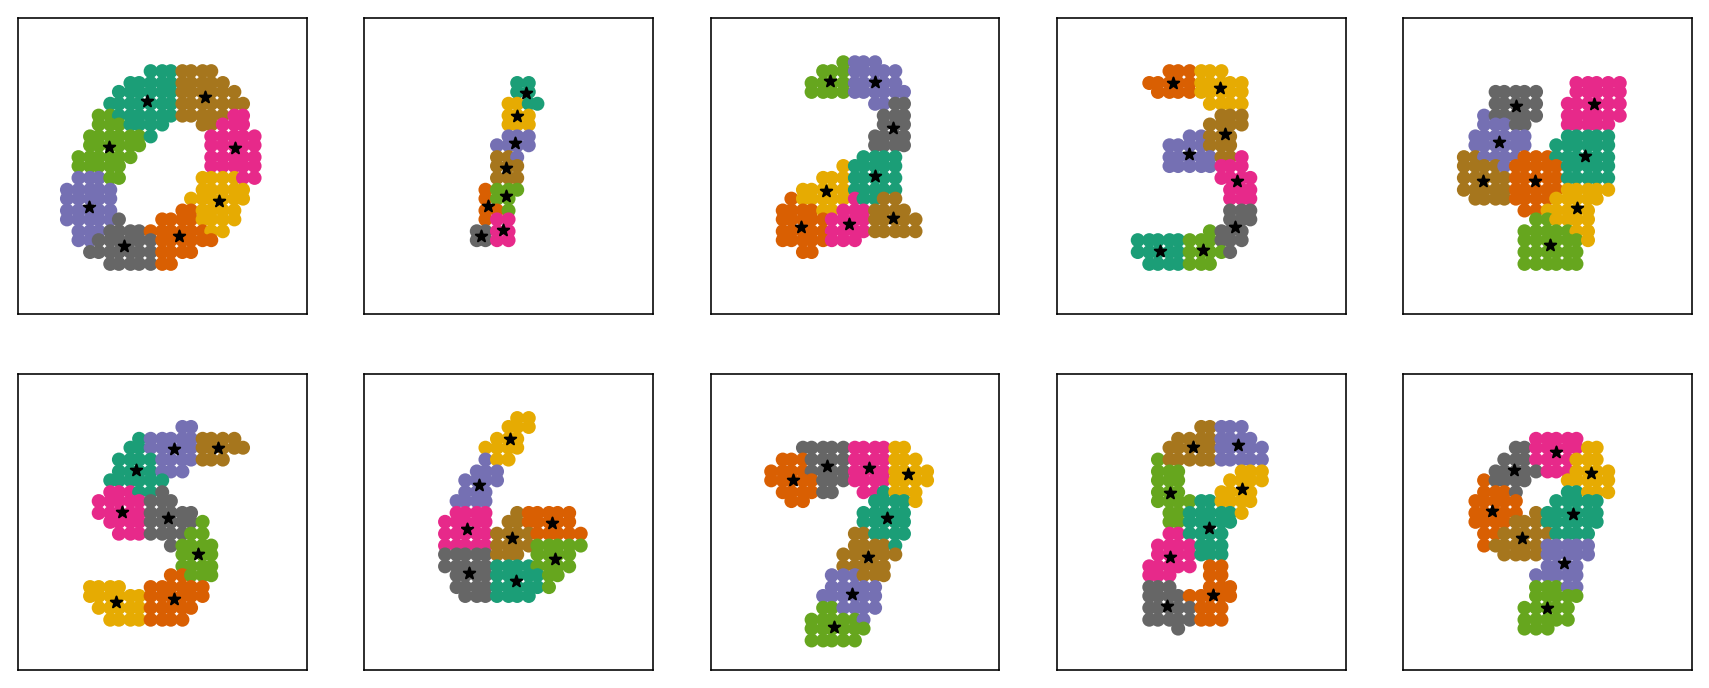

In [60]:
np.random.seed(2)
average_mnist = mnist.groupby('label').mean().astype('int64').values
thld = np.array([70,110,100,110,50,80,100,60,100,70])
#                0   1   2   3  4  5   6  7   8  9
centroids=[]
r, c = 2, 5
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img= average_mnist[i]
    img[img<thld[i]] = 0
    plot_mnist(img)
plt.show()

plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img= average_mnist[i]
    img[img<thld[i]] = 0
    kmt,xy = mnist2clusters(img, pixval_min=thld[i])
    plot_clusters(kmt,xy)
    centroids.append(kmt.cluster_centers_)
plt.show()

In [26]:
# plt.figure(figsize=(1,3))
# plt.scatter([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], c=[0,1,2,3,4,5,6,7], cmap='Dark2')
# plt.colorbar()

In [27]:
order=np.array([[0,4,2,7,1,5,3,6],#0
                [0,5,2,6,4,1,3,7],#1
                [4,2,7,0,5,1,3,6],#2
                [1,5,6,2,3,7,4,0],#3
                [7,2,6,1,0,3,5,4],#4
                [6,2,0,3,7,4,1,5],#5
                [5,2,3,7,0,4,1,6],#6
                [1,7,3,5,0,6,2,4],#7
                [6,4,0,1,7,3,5,2],#8
                [0,6,1,7,3,5,2,4]])#9

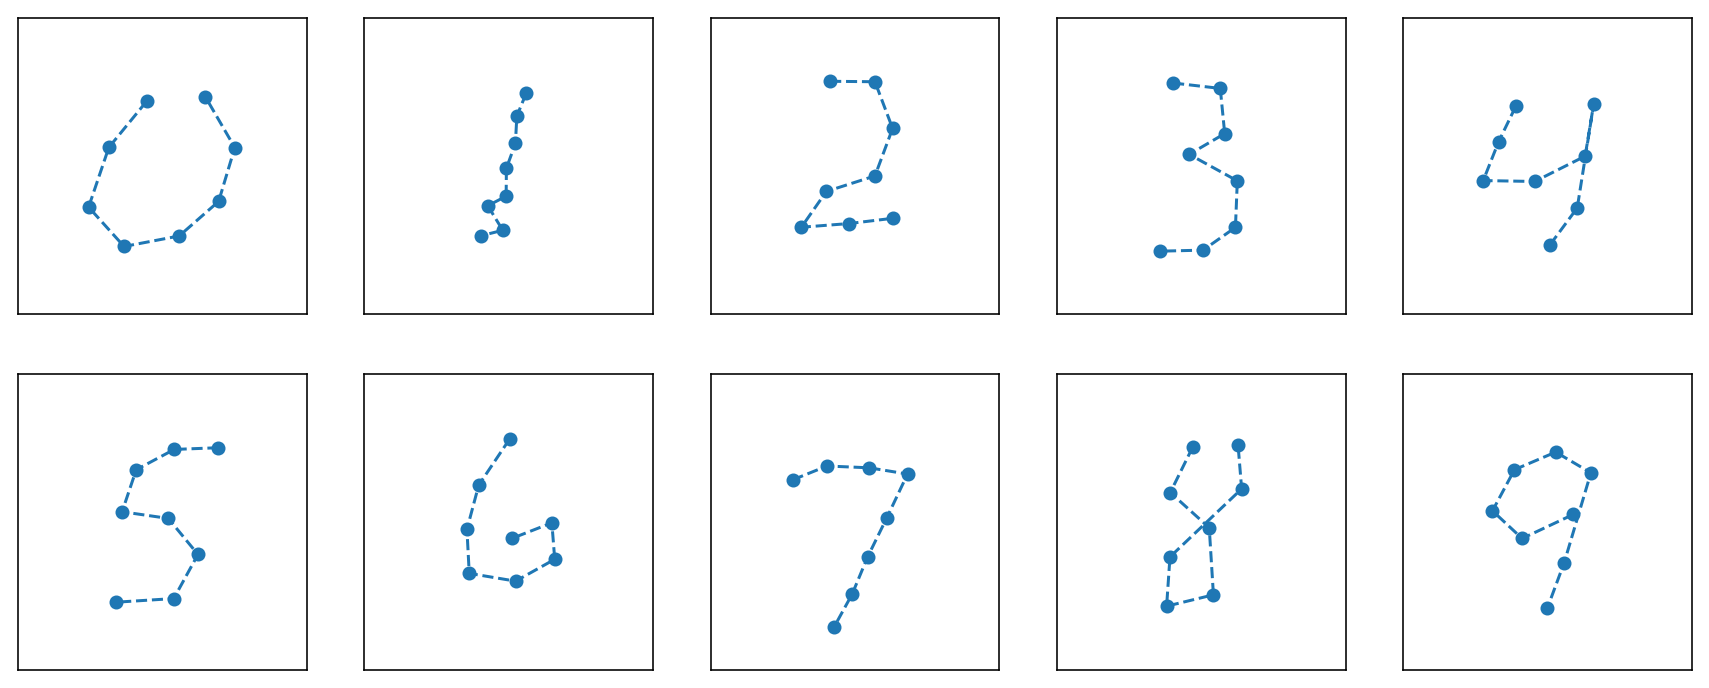

In [28]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    tmplt = centroids[i][order[i]]
    plt.plot(tmplt[:,0], tmplt[:,1], '--o')
    plt.xlim((0,100))
    plt.ylim((0,100))
    plt.xticks([])
    plt.yticks([])
plt.show()

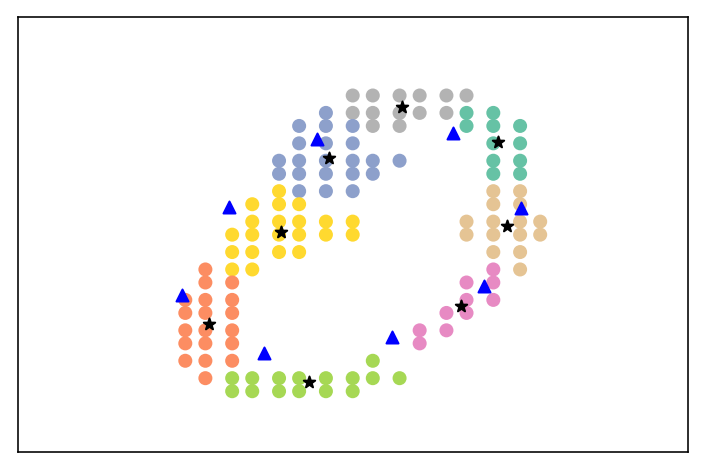

In [29]:
tmplt_0 = centroids[0][order[0]]
img_0 = img2coord(features.iloc[30].values, pixval_min=thld[0])
km0, xy0 = mnist2clusters(features.iloc[30].values, pixval_min=thld[i])
plot_clusters(km0, xy0)
plt.scatter(tmplt_0[:,0], tmplt_0[:,1], marker='^',color='b')

In [96]:
from sympy.utilities.iterables import multiset_permutations
perm = np.array(list(multiset_permutations(range(8))))

def mse(c1, c2):
    return np.mean((c1-c2)**2)

def mse_centroids(centroid_indx, tmplt, centroids):
    return mse(tmplt, centroids[perm[centroid_indx]])

def minimize(tmplt, centroids):
    mse_val = [mse_centroids(i, tmplt, centroids) for i in range(len(perm))]
    return centroids[perm[np.argmin(mse_val)]], np.min(mse_val)

def feature_extractor(img, label, thld_sc=1, return_clusters=False):
    tmplt = centroids[label][order[label]]
    km, xy = mnist2clusters(img, pixval_min=thld[label]*thld_sc)
    points8, _ = minimize(tmplt, km.cluster_centers_.astype('int64'))
    if return_clusters:
        return points8, km, xy
    return points8

def plot_exfeatures(coord, marker='--o', c='tab:blue',lim=(-1,101)):
    plt.plot(coord[:,0],coord[:,1], marker, color=c)
    plt.scatter(coord[0,0],coord[0,1], marker='s', color=c)
    plt.xlim(lim)
    plt.ylim(lim)
    plt.xticks([])
    plt.yticks([])

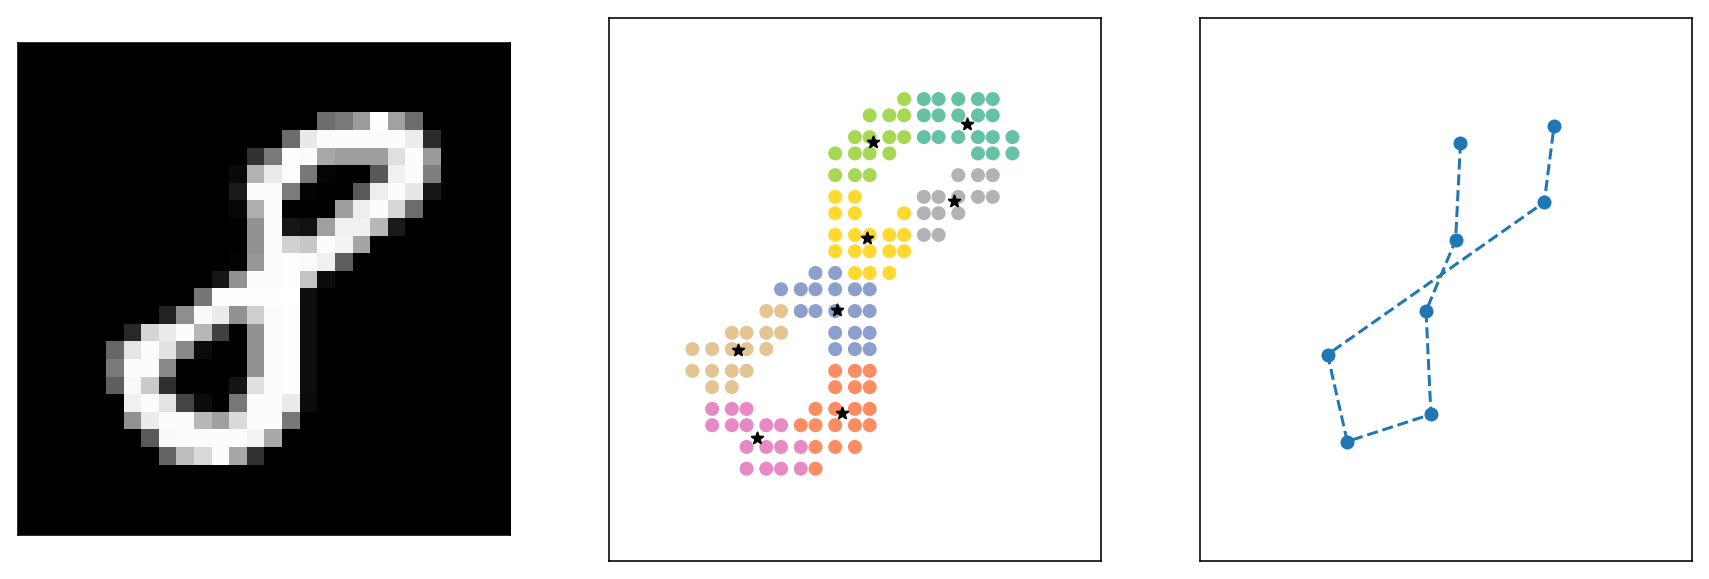

In [31]:
np.random.seed(0)
indx=401
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot_mnist(features.iloc[indx].values)
pts, kms, xys = feature_extractor(features.iloc[indx].values, label[indx], return_clusters=True)
plt.subplot(1,3,2)
plot_clusters(kms, xys)
plt.subplot(1,3,3)
plot_exfeatures(pts)
plt.show()

In [32]:
allmnist_f = mnist.drop('label', axis=1)
allmnist_l = mnist.label

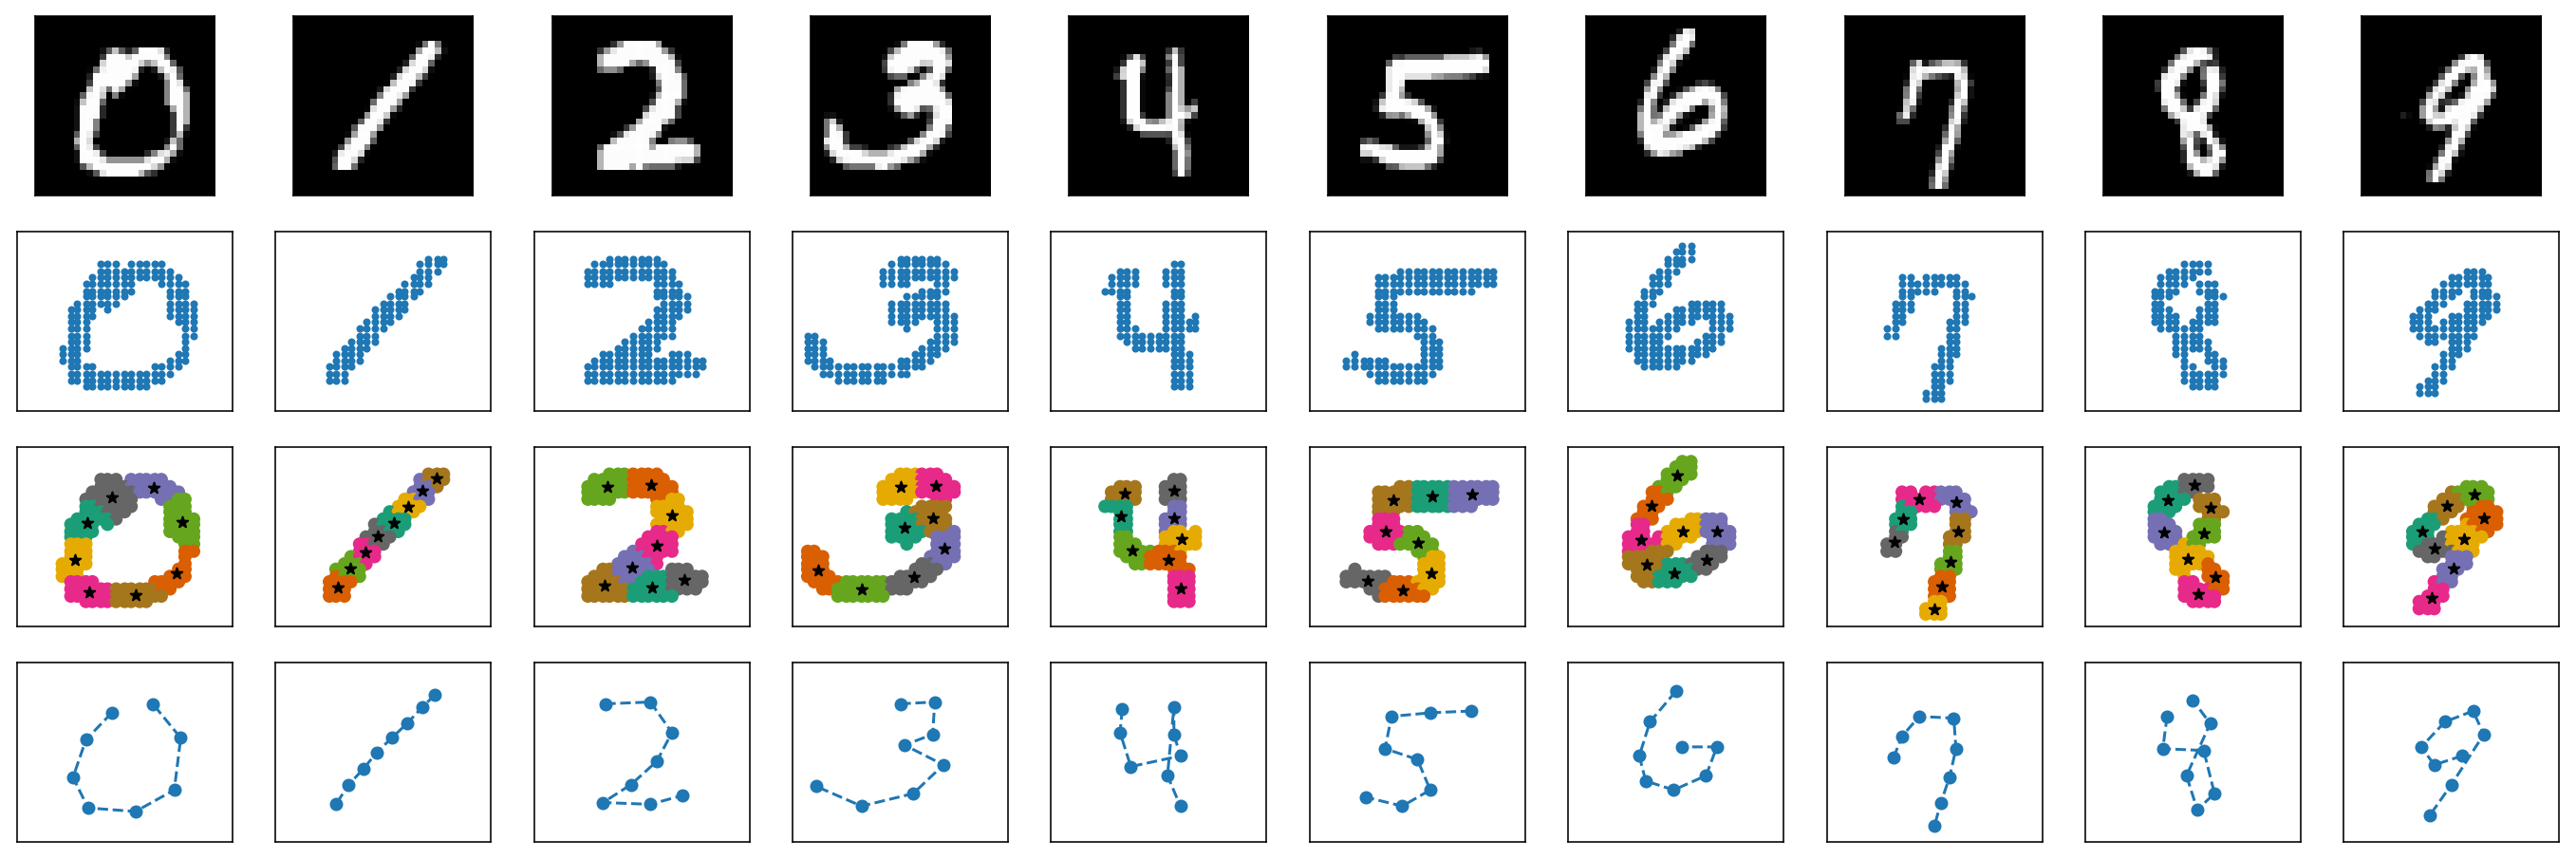

In [45]:
np.random.seed(18) #3,5,7,10,18*
samples = {i:allmnist_l[allmnist_l==i].sample(1, replace=False).index for i in range(10)}
plt.figure(figsize=(24,8))
for j in range(10):
    indx = samples[j][0]
    plt.subplot2grid((4,10),(0, j))
    plot_mnist(allmnist_f.iloc[indx].values)
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], thld_sc=1, return_clusters=True)
    plt.subplot2grid((4,10),(1, j))
    plot_coord(xys,'.')
    plt.subplot2grid((4,10),(2, j))
    plot_clusters(kms, xys)
    plt.subplot2grid((4,10),(3, j))
    plot_exfeatures(pts)

In [103]:
def get_boundary(coord):
    xmin = coord[:,0].min()
    xmax = coord[:,0].max()
    ymin = coord[:,1].min()
    ymax = coord[:,1].max()
    return xmin,ymin,xmax,ymax

def scale(coord):
    coord=coord.astype('float64')
    xmin,ymin,xmax,ymax = get_boundary(coord)
    x_o = (xmax + xmin)/2
    y_o = (ymax + ymin)/2
    coord -= [x_o,y_o]
    sc = 100/max(xmax-xmin, ymax-ymin)
    coord *= sc
    coord += 50
    return coord.astype('int64')

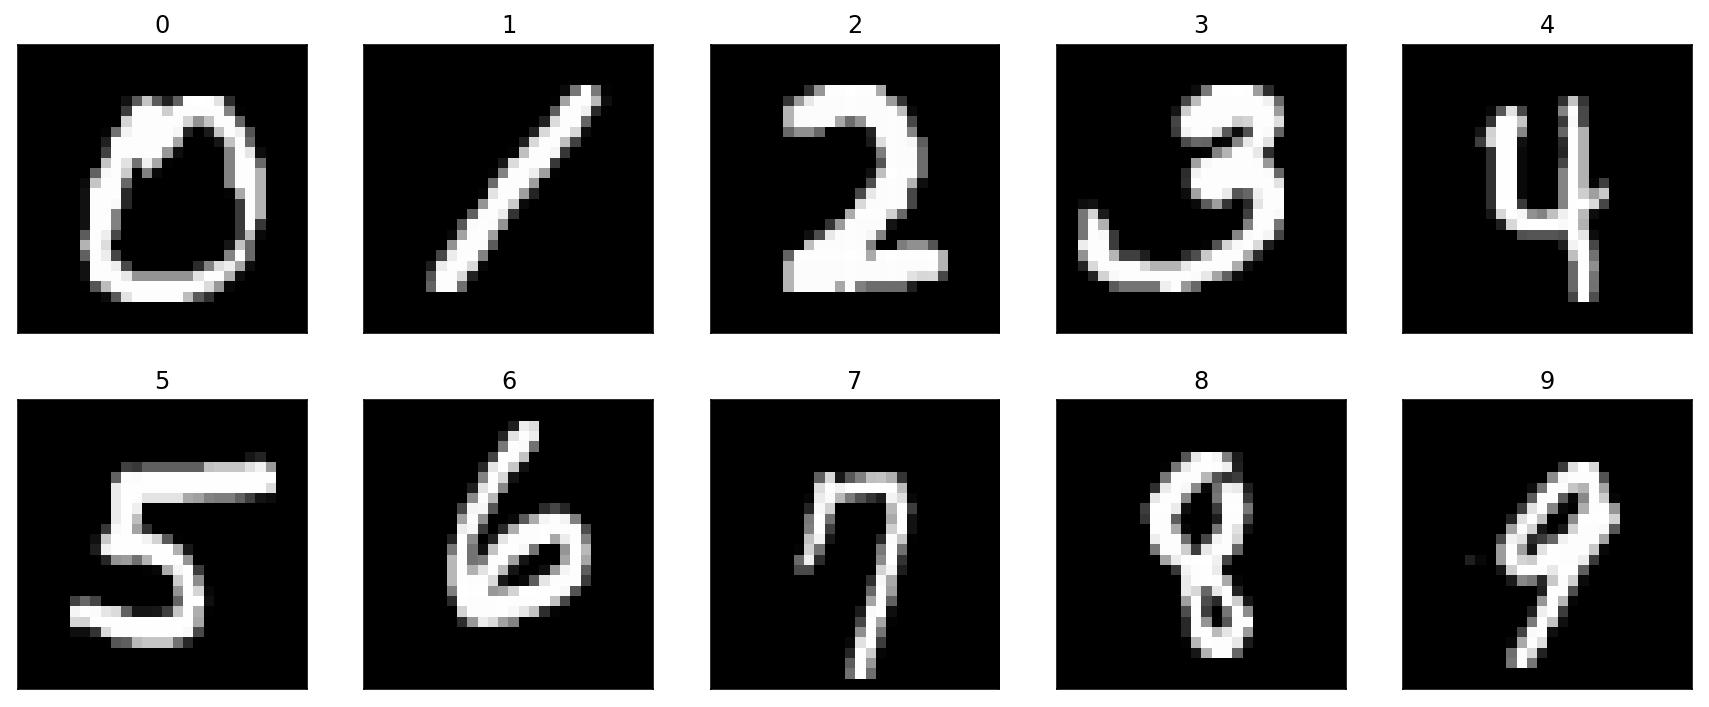

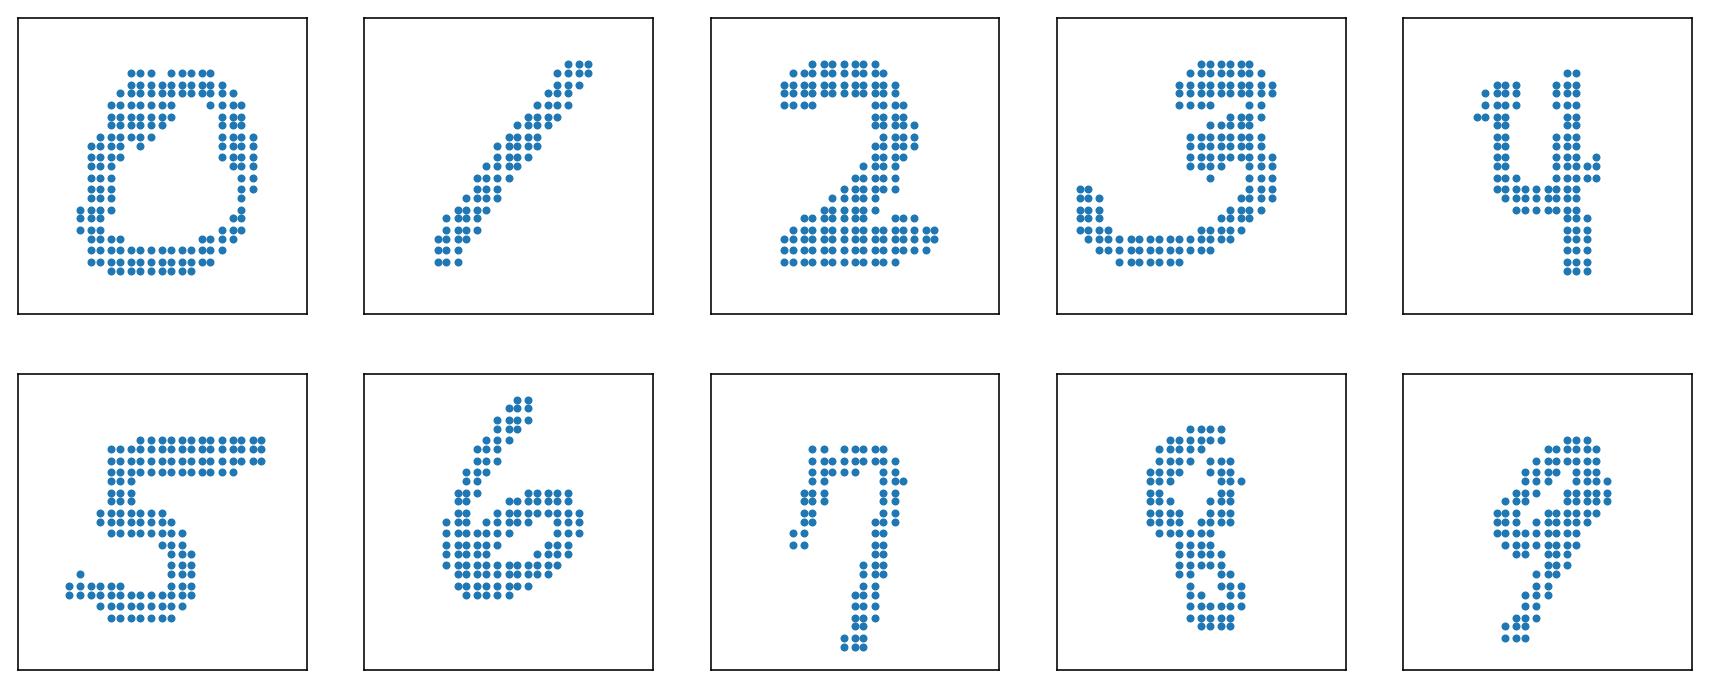

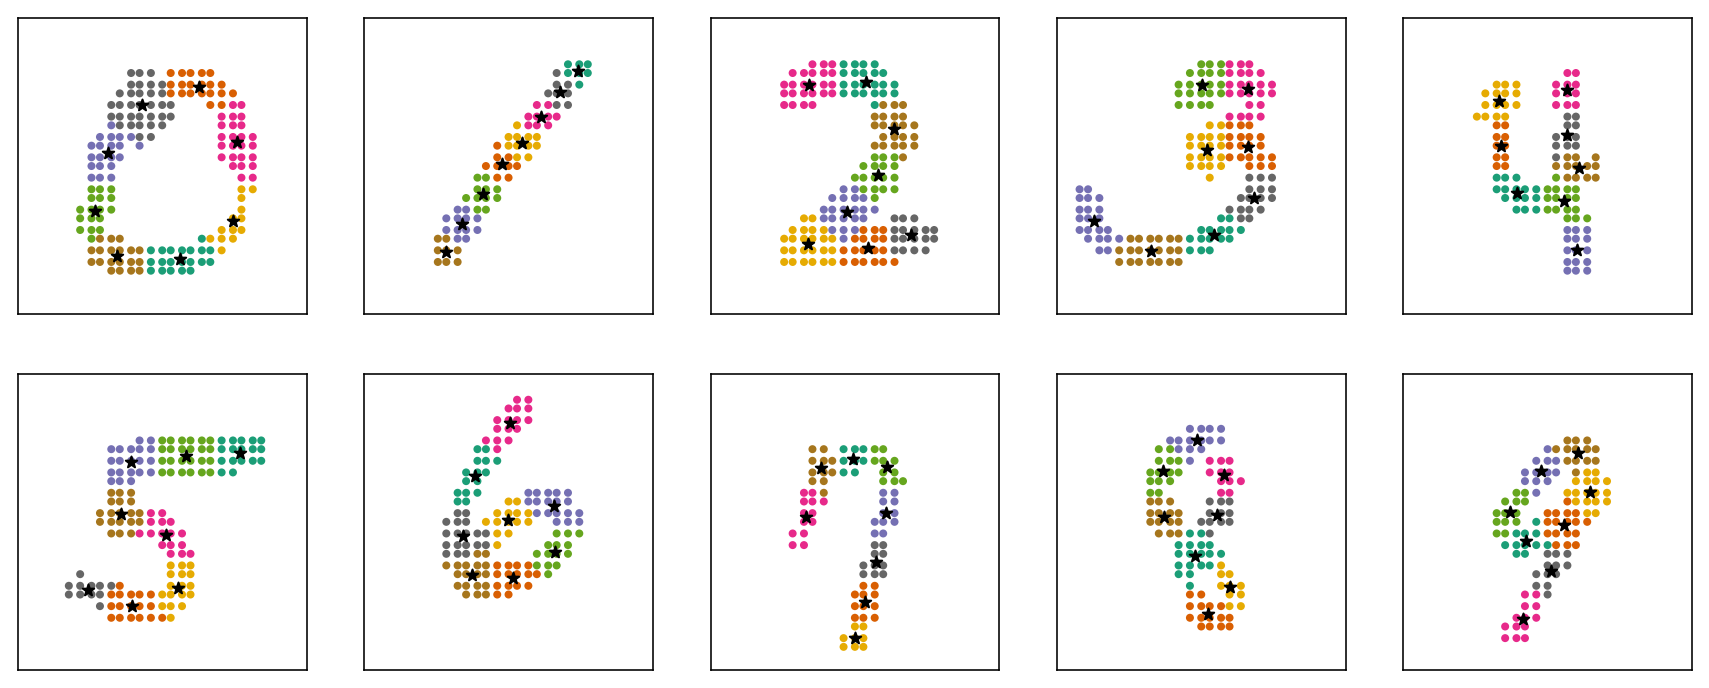

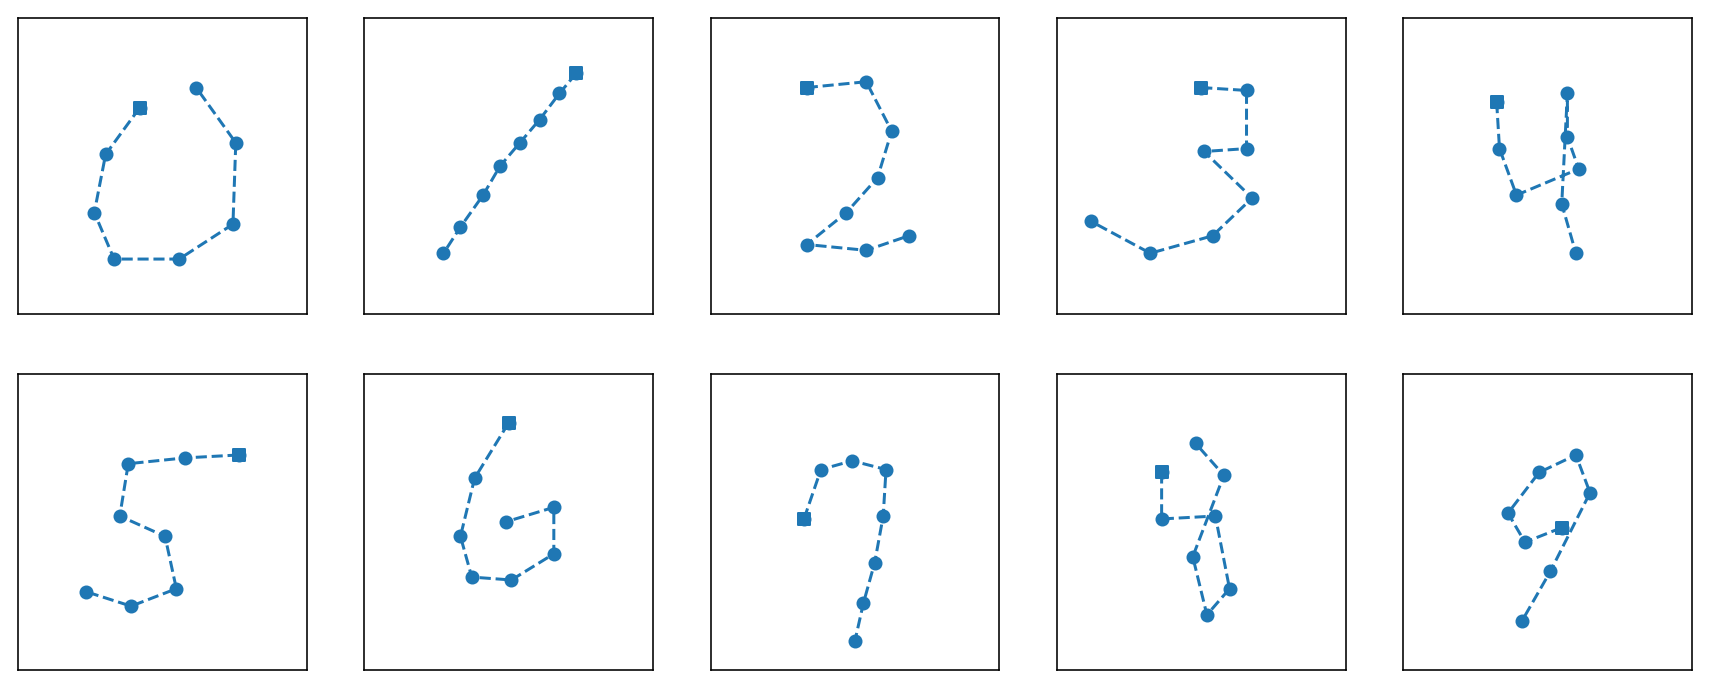

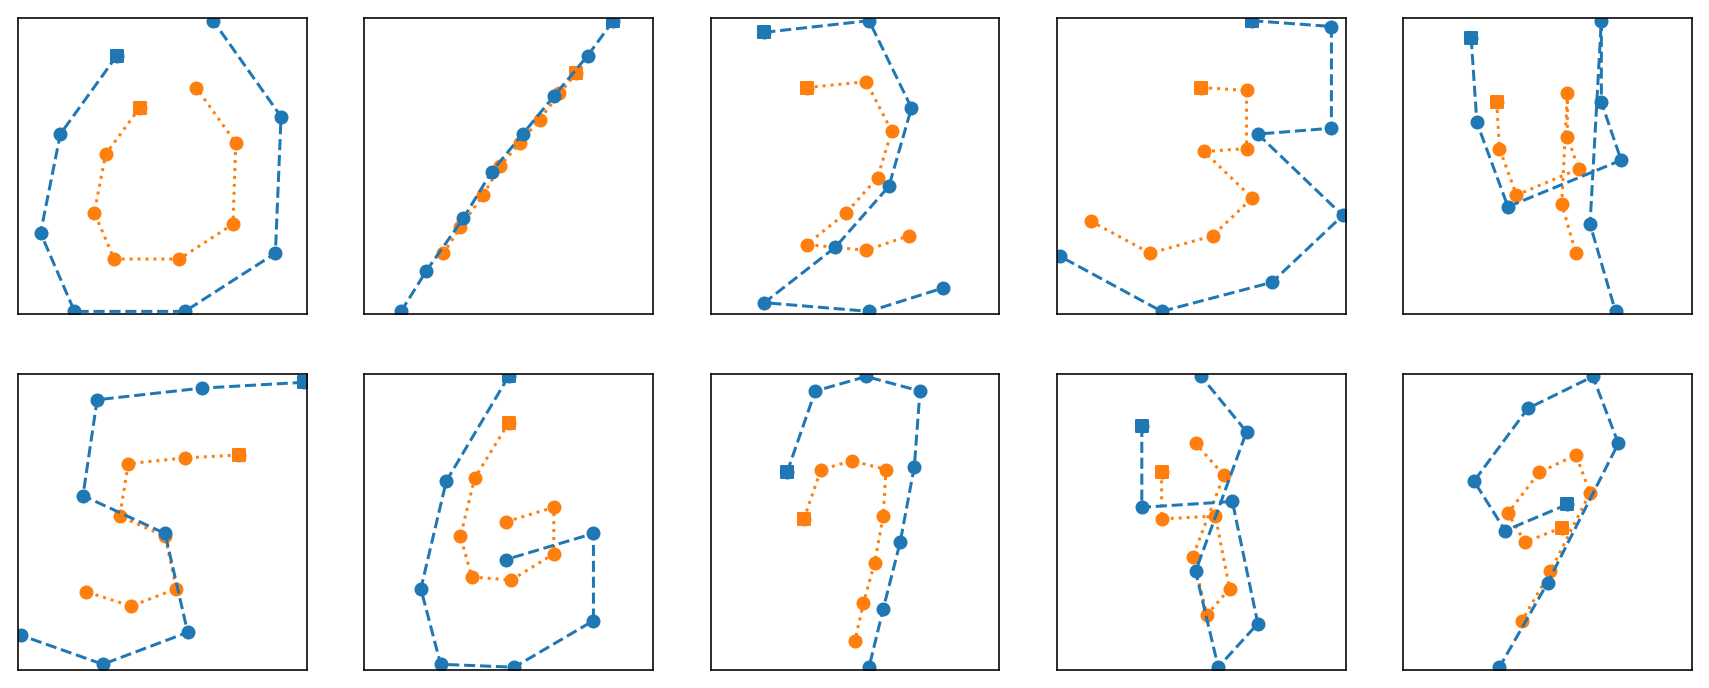

In [104]:
np.random.seed(2)
r, c = 2, 5
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(str(allmnist_l[indx]))
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], thld_sc=1, return_clusters=True)
    plot_coord(xys,'.')
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], thld_sc=1, return_clusters=True)
    plot_clusters(kms, xys, '.')
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], thld_sc=1, return_clusters=True)
    plot_exfeatures(pts)
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], thld_sc=1, return_clusters=True)
    plot_exfeatures(pts, ':o', c='tab:orange')
    plot_exfeatures(scale(pts))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [74]:
mnist_pendigits = pd.DataFrame(columns=['x1','y1','x2','y2','x3','y3','x4','y4','x5','y5','x6','y6','x7','y7','x8','y8'],dtype='int64')

In [ ]:
# for i in range(len(features)):
#     pts, kms, xys = feature_extractor(features.iloc[i].values, label[i], thld_sc=1, return_clusters=True)
#     mnist_pendigits.loc[i]=pts.reshape(-1)
#     if i%10==0:
#         print(i)
# mnist_pendigits.head()

In [35]:
mnist_pendigits['label']=label
mnist_pendigits.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,label
0,48,67,35,53,26,37,33,21,52,23,63,36,68,53,63,75,0
1,39,71,27,54,24,34,36,21,57,27,72,46,74,70,56,81,0
2,54,71,38,59,26,43,27,25,47,26,64,36,69,55,71,76,0
3,38,64,28,46,28,28,44,20,60,29,70,48,69,68,55,79,0
4,38,76,32,57,28,40,37,23,59,24,74,40,70,61,57,74,0


In [36]:
mnist_pendigits.to_csv('data/mnist_to_pendigits.csv',index=False)

6


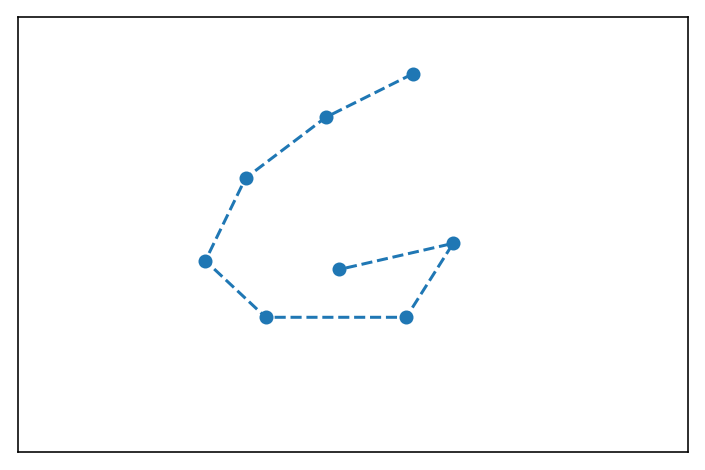

In [39]:
indx=304
print(mnist_pendigits.iloc[indx].label)
plot_exfeatures(mnist_pendigits.iloc[indx].drop('label').values.reshape(8,2))

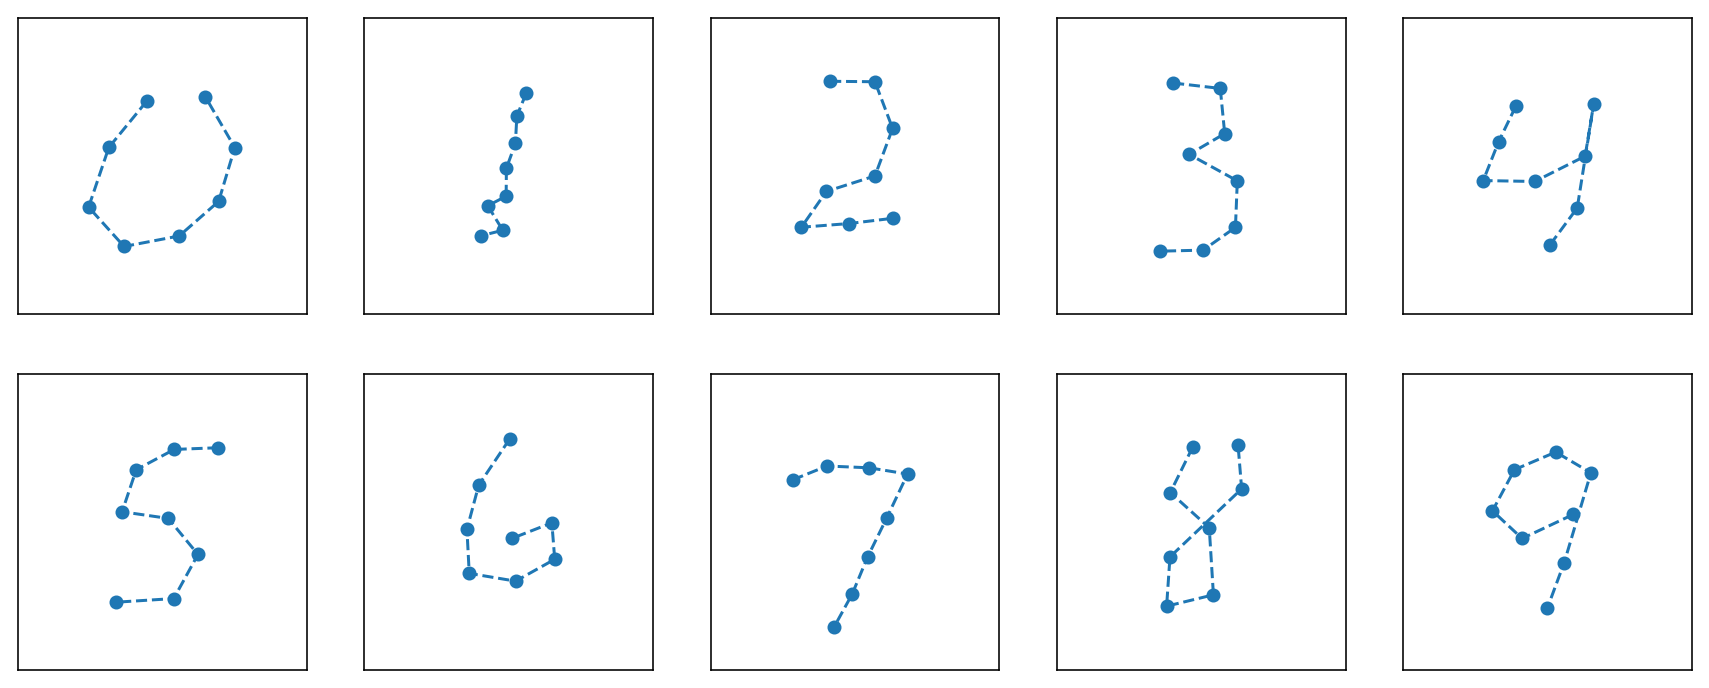

In [28]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    tmplt = centroids[i][order[i]]
    plt.plot(tmplt[:,0], tmplt[:,1], '--o')
    plt.xlim((0,100))
    plt.ylim((0,100))
    plt.xticks([])
    plt.yticks([])
plt.show()

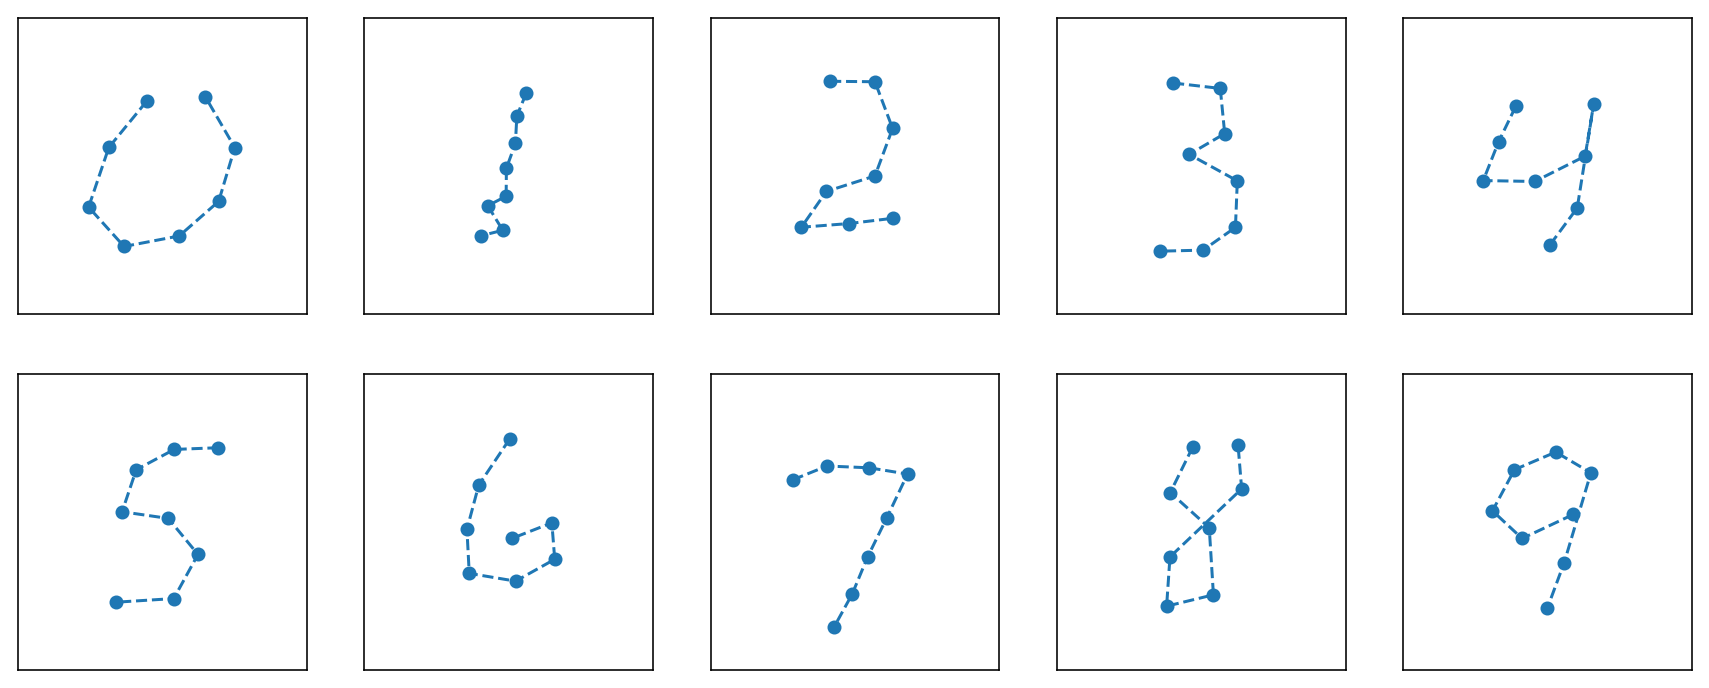

In [61]:
np.random.seed(18) #3,5,7,10,18*
samples = {i:allmnist_l[allmnist_l==i].sample(1, replace=False).index for i in range(10)}
plt.figure(figsize=(24,8))
for j in range(10):
    indx = samples[j][0]
    plt.subplot2grid((4,10),(0, j))
    plot_mnist(allmnist_f.iloc[indx].values)
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], thld_sc=1, return_clusters=True)
    plt.subplot2grid((4,10),(1, j))
    plot_coord(xys,'.')
    plt.subplot2grid((4,10),(2, j))
    plot_clusters(kms, xys)
    plt.subplot2grid((4,10),(3, j))
    plot_exfeatures(pts)

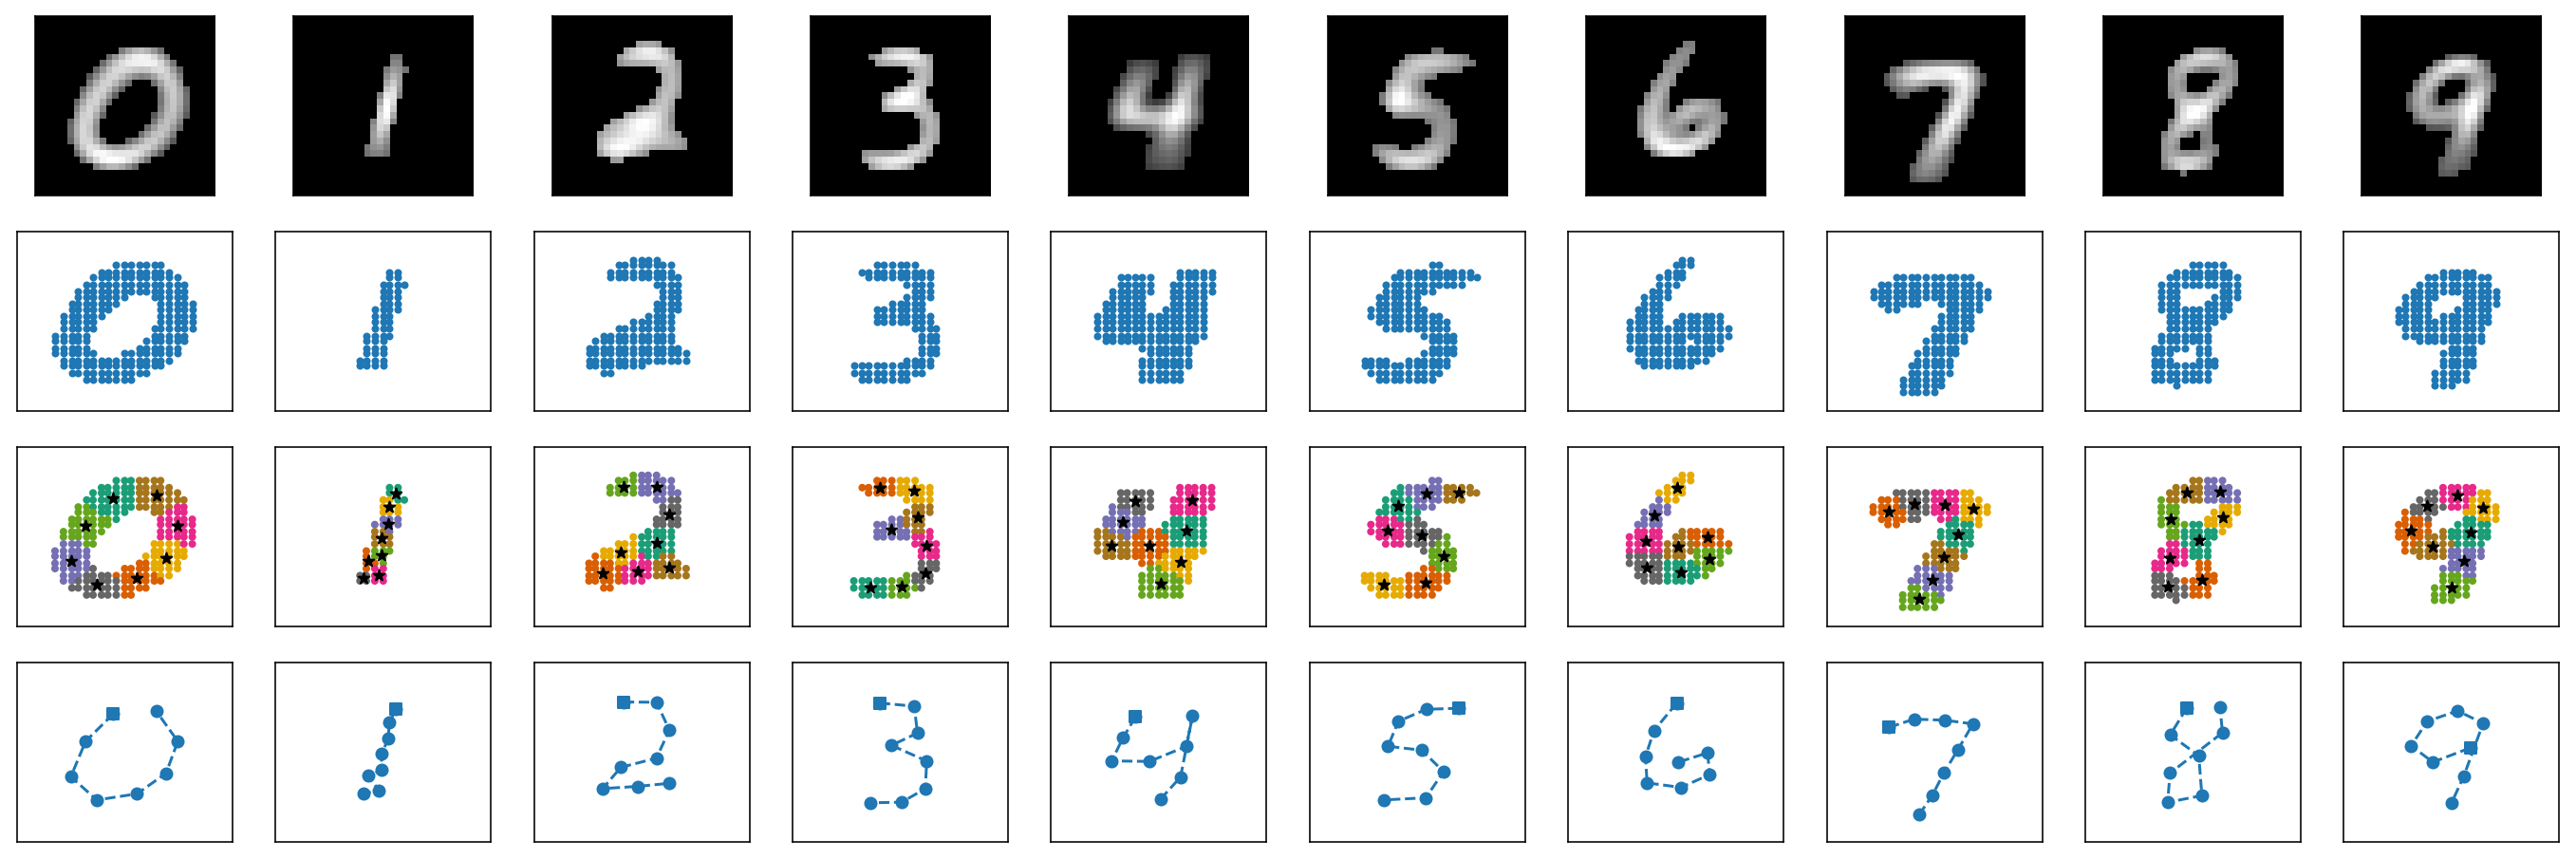

In [101]:
np.random.seed(2) #3,5,7,10,18*

plt.figure(figsize=(24,8))
for j in range(10):
    img= average_mnist[j]
    img[img<thld[j]] = 0
    plt.subplot2grid((4,10),(0, j))
    plot_mnist(img)
    kms,xys = mnist2clusters(img, pixval_min=thld[j])
    plt.subplot2grid((4,10),(1, j))
    plot_coord(xys,'.')
    plt.subplot2grid((4,10),(2, j))
    plot_clusters(kms, xys,'.')
    tmplt = centroids[j][order[j]]
    plt.subplot2grid((4,10),(3, j))
    plot_exfeatures(tmplt)